# Seleccion de modelo y entranamiento de clasificador 

## Importar Librerias necesarias

In [12]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from PIL import Image
from SRC.modelo_clasificacion_crt import CustomClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Variables de entorno

In [4]:


carpeta_preprocesadas = 'data/preprocesadas/'
train_normal =carpeta_preprocesadas+'train/NORMAL/'
train_pneumonia =carpeta_preprocesadas+'train/PNEUMONIA/'
test_normal =carpeta_preprocesadas+'test/NORMAL/'
test_pneumonia =carpeta_preprocesadas+'test/PNEUMONIA/'
val_normal =carpeta_preprocesadas+'val/NORMAL/'
val_pneumonia =carpeta_preprocesadas+'val/PNEUMONIA/'
dir_train =carpeta_preprocesadas+'train/'
dir_test =carpeta_preprocesadas+'test/'
dir_val =carpeta_preprocesadas+'val/'
salida_caracteristicas = 'data/caracteristicas/'
caracteristicas_train = salida_caracteristicas + 'X_train_features.npy'
etiquetas_train = salida_caracteristicas + 'y_train_labels.npy'
caracteristicas_test = salida_caracteristicas + 'X_test_features.npy'
etiquetas_test = salida_caracteristicas + 'y_test_labels.npy'
caracteristicas_val = salida_caracteristicas + 'X_val_features.npy'
etiquetas_val = salida_caracteristicas + 'y_val_labels.npy'

## inicializar el modelo

In [5]:
# 1. Inicializar la clase (usa 2048 como input_shape)
classifier_manager = CustomClassifier(input_shape=2048)

# 2. Compilar el modelo con las métricas deseadas
classifier_manager.compile_model(learning_rate=0.001)

I0000 00:00:1763869751.590703   19541 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9323 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Estructura del modelo

In [6]:
classifier_manager.show_architecture()

--- Resumen del Modelo Clasificador Personalizado ---


Model: "RX_Custom_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114,881 (4.25 MB)

 Trainable params: 1,114,881 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

## cargar caracteristicas extraidas y etiquetas

In [7]:
x_train_features = np.load(caracteristicas_train)
y_train_labels = np.load(etiquetas_train)
x_test_features = np.load(caracteristicas_test)
y_test_labels = np.load(etiquetas_test)
x_val_features = np.load(caracteristicas_val)
y_val_labels = np.load(etiquetas_val)

## ponderacion de clases

In [10]:
from sklearn.utils import class_weight
import numpy as np 

# --- ASUMIENDO que y_train_labels ya ha sido cargado:
# y_train_labels = np.load(etiquetas_train)
print(f"Número de etiquetas cargadas: {len(y_train_labels)}")

# 1. Cálculo de los Pesos de Clase
# Se calcula el peso inversamente proporcional a la frecuencia de cada clase.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels), # Obtiene [0, 1]
    y=y_train_labels
)

# 2. Conversión al formato de Diccionario (requerido por Keras)
# Resultado: {0: peso_normal, 1: peso_anormal}
class_weights_dict = dict(enumerate(class_weights))

print("\n--- Resultados de Ponderación ---")
print(f"Array de pesos: {class_weights}")
print(f"Diccionario de pesos (class_weights_dict): {class_weights_dict}")
print("---------------------------------")

Número de etiquetas cargadas: 5216

--- Resultados de Ponderación ---
Array de pesos: [1.9448173  0.67303226]
Diccionario de pesos (class_weights_dict): {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
---------------------------------


## entrenamiento de modelo

In [11]:
history = classifier_manager.model.fit(
    x_train_features, y_train_labels,
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict, 
    validation_data=(x_val_features, y_val_labels),
    verbose=1
)

Epoch 1/50


2025-11-23 04:00:59.920918: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f06040097a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 04:00:59.921217: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-23 04:01:00.081011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 04:01:00.394069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-23 04:01:00.594568: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-23 04:01:00.594641: I e

 48/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7860 - auc: 0.8611 - loss: 0.4637 - precision: 0.9103 - recall: 0.7899

I0000 00:00:1763870465.008117   19630 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8980 - auc: 0.9617 - loss: 0.2551 - precision: 0.9652 - recall: 0.8950 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.3125 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9473 - auc: 0.9870 - loss: 0.1376 - precision: 0.9849 - recall: 0.9435 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1449 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9500 - auc: 0.9901 - loss: 0.1231 - precision: 0.9858 - recall: 0.9463 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.0986 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9503 - auc: 0.9902 - loss: 0.1208 - precision: 0.9863 - recall: 0.9463 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0866 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s

In [13]:

# 1. Obtener las probabilidades (0 a 1)
y_pred_proba = classifier_manager.model.predict(x_test_features)

# 2. Convertir las probabilidades a clases binarias (0 o 1)
# Usamos el umbral estándar de 0.5. (Puedes ajustar este umbral si es necesario)
y_pred = (y_pred_proba > 0.5).astype(int) 

# Las etiquetas de clase (para el gráfico)
class_names = ['Normal (0)', 'Anormal (1)']

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


Matriz de Confusión calculada:
 [[163  71]
 [  4 386]]


<Figure size 800x800 with 0 Axes>

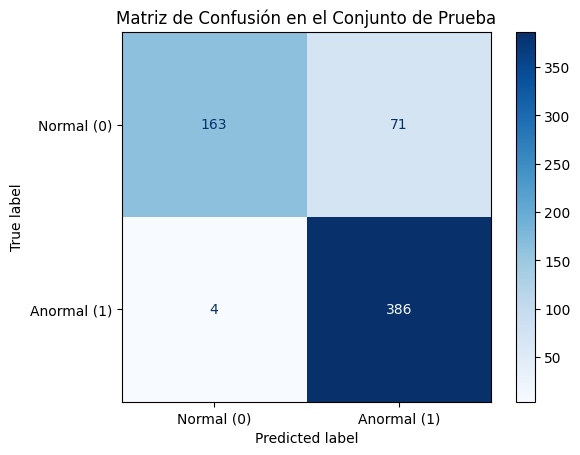

In [15]:
# 3. Calcular la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

print("Matriz de Confusión calculada:\n", cm)


# 4. Visualizar la matriz
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()